# Deep Learning with Flax

[Flax](https://flax.readthedocs.io/en/latest/) and [Optax](https://optax.readthedocs.io/en/latest/) are libraries for deep learning, written in Jax and maintained by Google. This notebook demonstrates how to use these libraries to build a model on the MNIST dataset.

## Imports and Configuration

In [ ]:
import warnings
from typing import Any, Dict, Tuple

import flax.linen as nn
import jax
import optax
import torchvision
from flax.training.train_state import TrainState
from jax import random, numpy as jnp
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

warnings.simplefilter("ignore")

## Get Dataset

We will lean on PyTorch's datasets and loaders.

In [2]:
import numpy as np


def flatten_and_cast(x: Any) -> jnp.ndarray:
    return jnp.ravel(jnp.array(x, dtype=jnp.float32))


def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


train_data = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=flatten_and_cast
)

test_data = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=flatten_and_cast
)

training_data_loader = DataLoader(
    dataset=train_data, batch_size=500, collate_fn=numpy_collate
)
test_data_loader = DataLoader(
    dataset=test_data, batch_size=1000, collate_fn=numpy_collate
)
print(f"{len(train_data):,} instances of training data")
print(f"{len(test_data):,} instances of training data")

60,000 instances of training data
10,000 instances of training data


Inspect a single instance of training data.

label = 5


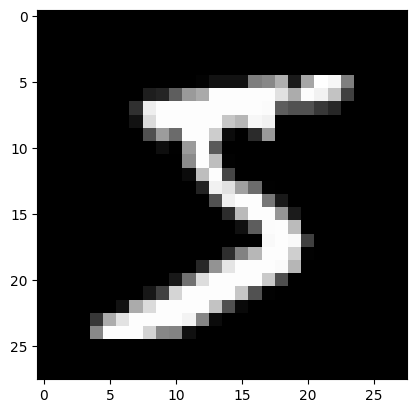

In [3]:
data_instance, data_label = train_data[0]
print(f"label = {data_label}")
_ = plt.imshow(data_instance.reshape(28, 28), cmap="gray")

## Define Simple Neural Network Classification Model

Start by defining the network that we want to train.

In [4]:
class MLP(nn.Module):
    n_hidden: int
    n_classes: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden, name="hidden_layer")(x)
        x = nn.relu(x)
        x = nn.Dense(self.n_classes, name="output_layer")(x)
        return x


model = MLP(28 * 28, 10)
model

MLP(
    # attributes
    n_hidden = 784
    n_classes = 10
)

And then the training routine to use with it.

In [5]:
def loss(params: optax.Params, X: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    loss_values = optax.softmax_cross_entropy(
        model.apply(params, X), jax.nn.one_hot(y, 10)
    )
    return loss_values.mean()


def compute_metrics(training_state: TrainState, X: jnp.ndarray, y: jnp.ndarray):
    logits = training_state.apply_fn(training_state.params, X)
    loss = optax.softmax_cross_entropy(
        logits=logits, labels=jax.nn.one_hot(y, 10)
    ).mean()
    accuracy = jnp.mean(jnp.argmax(logits, -1) == y)
    metrics = {
        "loss": loss.tolist(),
        "accuracy": accuracy.tolist(),
    }
    return metrics


def fit(n_epochs: int = 10, learning_rate: float = 0.01) -> optax.Params:
    @jax.jit
    def process_batch(
        training_state: TrainState, X: jnp.ndarray, y: jnp.ndarray
    ) -> TrainState:
        loss_grads = jax.grad(loss)(training_state.params, X, y)
        return training_state.apply_gradients(grads=loss_grads)

    def process_epoch(
        training_state: TrainState,
    ) -> Tuple[TrainState, Dict[str, float]]:
        for X, y in training_data_loader:
            training_state = process_batch(training_state, X, y)
        metrics = compute_metrics(training_state, X, y)
        return training_state, metrics

    key1, key2 = random.split(random.PRNGKey(0))
    training_state = TrainState.create(
        apply_fn=model.apply,
        params=model.init(key2, random.normal(key1, (28 * 28,))),
        tx=optax.sgd(learning_rate=learning_rate),
    )

    for n in range(n_epochs):
        training_state, metrics = process_epoch(training_state)
        print(f"epoch={n}; metrics={metrics}")
    return training_state.params

In [6]:
trained_params = fit()

epoch=0; metrics={'loss': 0.2294992208480835, 'accuracy': 0.9340000152587891}
epoch=1; metrics={'loss': 0.17606227099895477, 'accuracy': 0.9620000720024109}
epoch=2; metrics={'loss': 0.15006238222122192, 'accuracy': 0.9700000286102295}
epoch=3; metrics={'loss': 0.1338450163602829, 'accuracy': 0.9720000624656677}
epoch=4; metrics={'loss': 0.11482236534357071, 'accuracy': 0.9760000705718994}
epoch=5; metrics={'loss': 0.10640661418437958, 'accuracy': 0.9780000448226929}
epoch=6; metrics={'loss': 0.09827155619859695, 'accuracy': 0.9780000448226929}
epoch=7; metrics={'loss': 0.09185998886823654, 'accuracy': 0.9780000448226929}
epoch=8; metrics={'loss': 0.08489469438791275, 'accuracy': 0.9800000190734863}
epoch=9; metrics={'loss': 0.07957303524017334, 'accuracy': 0.9820000529289246}


In [10]:
def predict(X: jnp.ndarray) -> float:
    logit = model.apply(trained_params, X)
    return jnp.argmax(logit, -1).tolist()


correct = 0
for X, y in test_data_loader:
    y_pred = predict(X)
    correct += (y_pred == y).sum()
accuracy = correct / len(test_data)
print(f"test_data accuracy = {accuracy}")

test_data accuracy = 0.9462


In [8]:
predict(data_instance)

5